In [323]:
import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
import sklearn
from sklearn import preprocessing, model_selection
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import string
from string import *
import pymongo
from collections import Counter
from pandas.plotting import scatter_matrix
from sklearn.decomposition import PCA

In [316]:
mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']
results_coll = db['search_results']

In [362]:
cursor = recipes_coll.find()
chili_recipes = []
recipe_ids = []
for recipe in cursor:
    if recipe['category']['lvl_2'] == 'Chili':
        chili_recipes.append(recipe)
        recipe_ids.append(recipe['id'])

In [363]:
ingredients = Counter()
for recipe in chili_recipes:
    for ing in recipe['ingredients'].keys():
        ingredients[ing] += 1
print('Number of unique ingredients :', len(ingredients))

Number of unique ingredients : 424


In [364]:
common_ingredients = []
for item, count in ingredients.most_common():
    if count > 1:
        common_ingredients.append(item)
print('Number of common ingredients :', len(common_ingredients))

Number of common ingredients : 188


In [263]:
def _approximate_servings(recipe, df):
    recipe_qtys = []
    df_means = []
    for ing, qty in recipe['ingredients'].items():
        if ing in chili_df.columns:
            recipe_qtys.append(qty['normalized_qty'])
            ing_vals = chili_df[chili_df[ing] != 0][ing]
            df_means.append(np.mean(ing_vals))
    qtys_array = np.array(recipe_qtys)
    df_means_array = np.array(df_means)
    count = 1
    while True:
        err = np.mean(abs(qtys_array/count - df_means_array)) * count
        next_err = np.mean(abs(qtys_array/(count+1) - df_means_array)) * (count+1)
        if next_err > err:
            return count
        count += 1
        err = next_err

In [264]:
actual = []
approx = []
for recipe in chili_recipes:
    servings = recipe['directions']['servings']
    actual.append(servings if servings else 0)
    approx.append(_approximate_servings(recipe, chili_df))
    

(0.08482339955849838, 21)

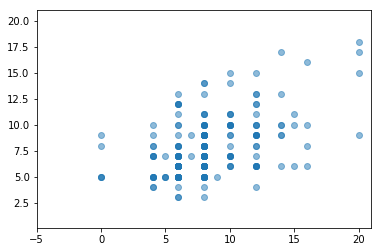

In [325]:
fig, ax = plt.subplots()
ax.scatter(actual, approx, alpha=.5)
ax.set_xlim(right=21)
ax.set_ylim(top=21)

In [336]:
def get_label_names(recipes, cat_lvl=2):
    labels = []
    key = 'lvl_{}'.format(cat_lvl)
    for recipe in recipes:
        labels.append(recipe['category'][key])
    return labels

def get_label_numbers(label_names):
    ordered_names = [key for key, val in Counter(label_names).most_common()]
    return [ordered_names.index(label) for label in label_names]

In [338]:
chili_labels = get_label_names(chili_recipes,3)
chili_label_nums = get_label_numbers(chili_labels)

In [ ]:
print('      Actual servings :', actual)
print('Approximated servings :', approx)

In [314]:
def create_dataframe(recipes, cutoff=2):
    recipe_ids = _get_recipe_ids(recipes)
    common_ingredients = _get_common_ingredients(recipes, cutoff=cutoff)
    df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
    unknown_servings = []
    for recipe in recipes:
        idx = recipe['id']
        servings = recipe['directions']['servings']
        if not servings:
            unknown_servings.append(recipe)
            #print('Servings missing')
            continue
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    # Determine approx servings for recipes where it is not specified
    for recipe in unknown_servings:
        servings = _approximate_servings(recipe, df)
        recipe['directions']['approx_servings'] = servings
    # Apply approx servings to recipes and insert data into dataframe
    for recipe in unknown_servings:
        servings = recipe['directions']['approx_servings']
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    return df

def _get_recipe_ids(recipes):
    recipe_ids = []
    for recipe in recipes:
        recipe_ids.append(recipe['id'])
    return recipe_ids

def _approximate_servings(recipe, df):
    recipe_qtys = []
    df_means = []
    for ing, qty in recipe['ingredients'].items():
        if ing in df.columns:
            recipe_qtys.append(qty['normalized_qty'])
            ing_vals = df[df[ing] != 0][ing]
            df_means.append(np.mean(ing_vals))
    qtys_array = np.array(recipe_qtys)
    df_means_array = np.array(df_means)
    count = 1
    while True:
        err = np.mean(abs(qtys_array/count - df_means_array)) * count
        next_err = np.mean(abs(qtys_array/(count+1) - df_means_array)) * (count+1)
        if next_err > err:
            return count
        count += 1
        err = next_err
        
def _get_common_ingredients(recipes, cutoff=2):
    ingredients = Counter()
    for recipe in recipes:
        for ing in recipe['ingredients'].keys():
            ingredients[ing] += 1
    #print('Number of unique ingredients :', len(ingredients))
    common_ingredients = []
    for item, count in ingredients.most_common():
        if count >= cutoff:
            common_ingredients.append(item)
    #print('Number of common ingredients :', len(common_ingredients))
    return common_ingredients

In [266]:
chili_df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
unknown_servings = []
for recipe in chili_recipes:
    idx = recipe['id']
    servings = recipe['directions']['servings']
    if not servings:
        unknown_servings.append(recipe)
        print('Servings missing')
        continue
    for ing, qty in recipe['ingredients'].items(): 
        norm_qty = qty['normalized_qty']
        if ing in chili_df.columns:
            chili_df.loc[idx, ing] = norm_qty / servings
# Determine approx servings for recipes where it is not specified
for recipe in unknown_servings:
    servings = _approximate_servings(recipe, chili_df)
    recipe['directions']['approx_servings'] = servings
# Apply approx servings to recipes and insert data into dataframe
for recipe in unknown_servings:
    servings = recipe['directions']['approx_servings']
    for ing, qty in recipe['ingredients'].items(): 
        norm_qty = qty['normalized_qty']
        if ing in chili_df.columns:
            chili_df.loc[idx, ing] = norm_qty / servings
chili_df

Servings missing
Servings missing
Servings missing
Servings missing
Servings missing


,onion,chili powder,cumin,tomato,garlic,beef,bell pepper,salt,oregano,kidney beans,...,beef stew meat,butter beans,lemon juice,chipotle chile powder,corn chip,chile pepper,beef bouillon,strong coffee,chicken meat,vegetable protein
214843,2.000000,0.083333,0.020833,3.333333,0.083333,3.333333,1.333333,0.041667,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26462,2.000000,0.125000,0.020833,0.000000,0.000000,4.000000,0.750000,0.000000,0.000000,1.875000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15386,1.142857,0.178571,0.000000,0.000000,0.000000,2.285714,0.000000,0.047619,0.000000,2.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16188,2.000000,0.125000,0.000000,1.208333,0.416667,4.000000,0.000000,0.000000,0.000000,3.750000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8835,1.600000,0.100000,0.033333,2.900000,0.200000,0.000000,1.200000,0.008333,0.033333,3.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13067,0.000000,0.166667,0.027778,0.000000,0.000000,2.666667,1.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24406,1.333333,0.000000,0.000000,1.666667,0.000000,5.333333,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23118,1.333333,0.166667,0.000000,0.000000,0.083333,4.000000,0.000000,0.000000,0.013889,2.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15868,1.333333,0.166667,0.083333,2.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80760,1.333333,0.416667,0.055556,0.000000,0.250000,6.666667,1.000000,0.000000,0.055556,2.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [367]:
chili_df = create_dataframe(chili_recipes, cutoff=5)
means = np.mean(chili_df, axis=0)
stds = np.std(chili_df, axis=0)
chili_scaled = (chili_df - means) / stds

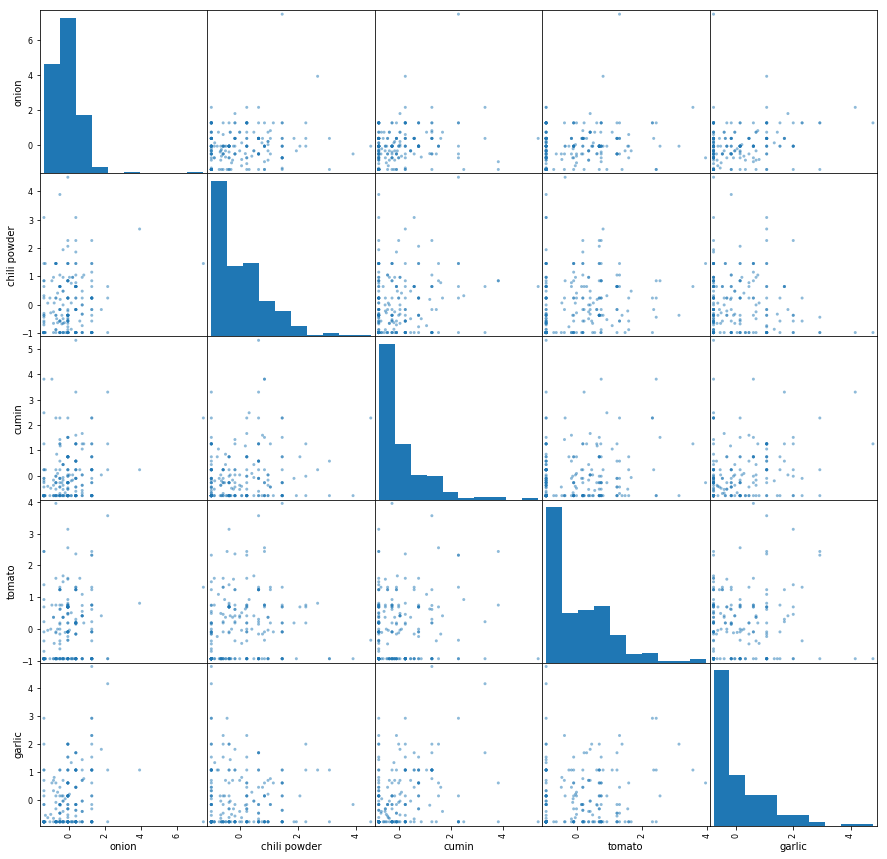

In [368]:

scatter_matrix(chili_scaled.iloc[:,:5], figsize=(15,15));

In [358]:
i = chili_scaled['onion'].idxmax()
j = chili_scaled['garlic'].idxmax()

In [360]:
for recipe in chili_recipes:
    if recipe['id'] == j:
        print(recipe)
        break

{'_id': ObjectId('5ca67b30c6d0b01a17821ef0'), 'id': 245409, 'name': 'Seafood Chili', 'href': 'https://www.allrecipes.com/recipe/245409/seafood-chili/', 'category': {'lvl_1': 'Soups, Stews and Chili', 'lvl_2': 'Chili', 'lvl_3': None}, 'rating_info': None, 'submitter_info': {'id': 2827713, 'name': 'Jay', 'followers': 0, 'href': 'https://www.allrecipes.com/cook/2827713/'}, 'ingredients': {'butter': {'quantity': 0.25, 'units': 'cup', 'normalized_qty': 2.0}, 'tomato': {'quantity': -1, 'units': 'combined', 'normalized_qty': 40.0}, 'bell peppers inch piece': {'quantity': 2.0, 'units': 'each', 'normalized_qty': 2.0}, 'garlic': {'quantity': 2.0, 'units': 'head', 'normalized_qty': 40.0}, 'green onion': {'quantity': 3.0, 'units': 'each', 'normalized_qty': 1.5}, 'kidney beans': {'quantity': 8.0, 'units': 'ounce', 'normalized_qty': 8.0}, 'baby corn': {'quantity': 8.0, 'units': 'ounce', 'normalized_qty': 8.0}, 'celery': {'quantity': 2.0, 'units': 'stalk', 'normalized_qty': 4.0}, 'chili powder': {'qu

In [274]:
n_features = chili_df.shape[1]
model = Sequential()
model.add(Dense(20,  activation='relu', input_shape=(n_features,)))
#model.add(Dense(10,  activation='relu'))
model.add(Dense(2,    activation='linear', name="bottleneck"))
#model.add(Dense(10,  activation='relu'))
model.add(Dense(20,  activation='relu'))
model.add(Dense(n_features,  activation='linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [341]:
X = chili_df.values

In [342]:
means = np.mean(chili_df, axis=0)
stds = np.std(chili_df, axis=0)

In [343]:
chili_scaled = (chili_df - means) / stds

In [344]:
X_scaled = chili_scaled.values

In [282]:
history = model.fit(X_scaled, X_scaled, batch_size=60, epochs=10000, verbose=None)

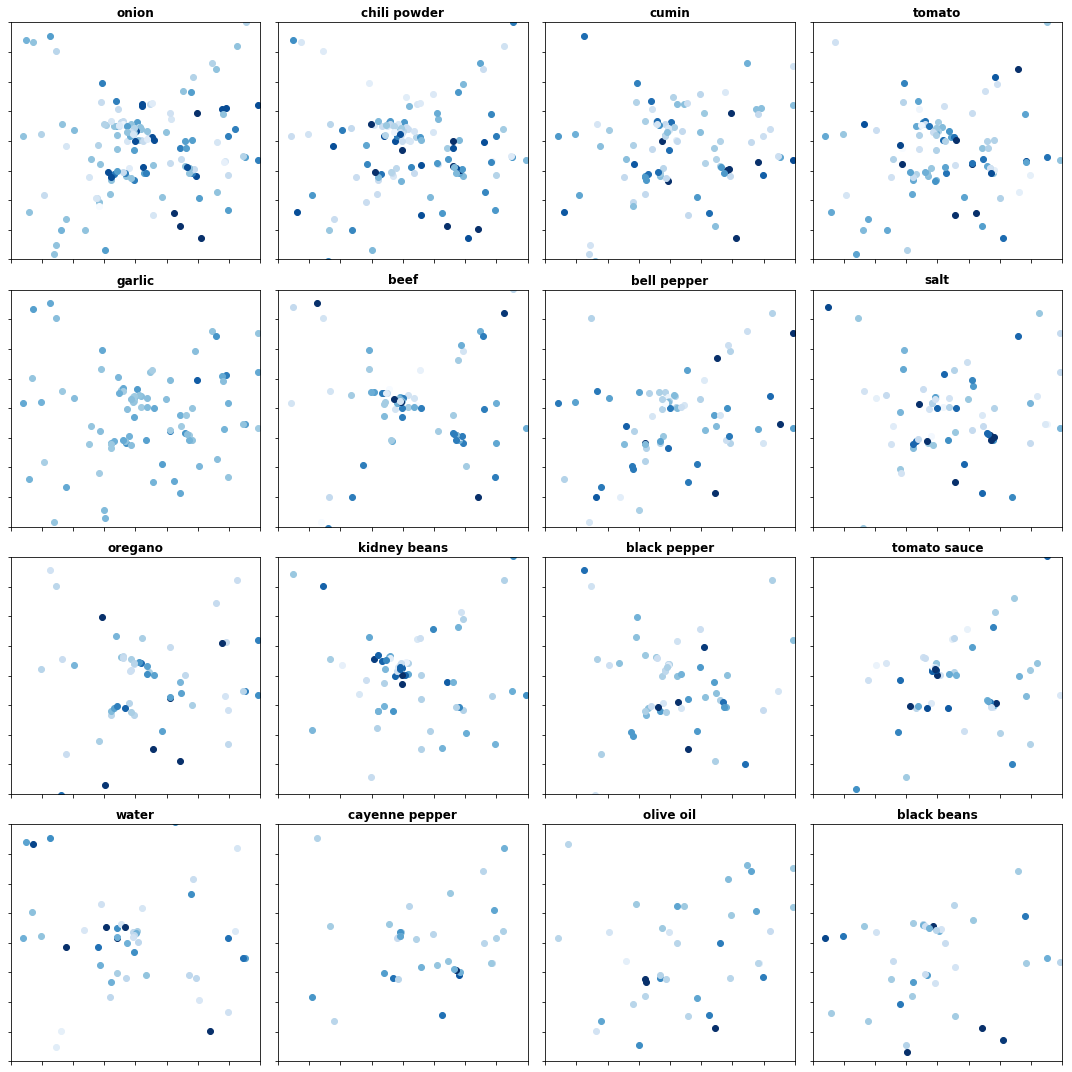

In [285]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
z_enc = encoder.predict(X_scaled)  # bottleneck representation

fig, axs = plt.subplots(4, 4,figsize=(15, 15), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ing = chili_df.columns[i]
    alpha= (chili_df[ing] != 0).astype(float).values
    mean_ing = np.mean(chili_df[chili_df[ing]!=0][ing])
    std_ing = np.std(chili_df[chili_df[ing]!=0][ing])
    color = [cm.Blues((val-(mean_ing)) / (3*std_ing) + 0.5) for val in chili_df[ing]]
    for j in range(len(z_enc)):
        z0 = z_enc[j, 0]
        z1 = z_enc[j, 1]
        ax.scatter(z0, z1, color=color[j], alpha=alpha[j])
    ax.set_title(ing, fontweight='bold')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(left=-20, right=20)
    ax.set_ylim(bottom=-20, top=20)
fig.tight_layout()

(-20, 20)

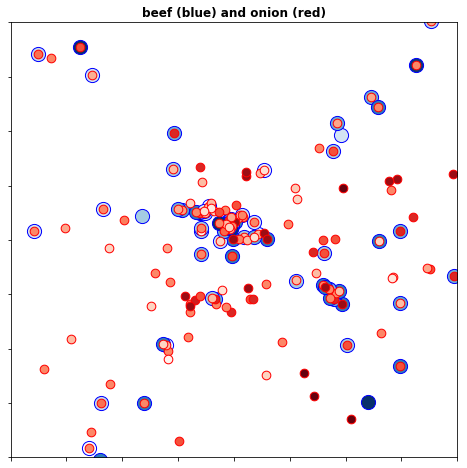

In [313]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
z_enc = encoder.predict(X_scaled)
ings = ['beef','onion']
fig, ax = plt.subplots(figsize=(8, 8))
ing = ings[0]
alpha= (chili_df[ing] != 0).astype(float).values
mean_ing = np.mean(chili_df[chili_df[ing]!=0][ing])
std_ing = np.std(chili_df[chili_df[ing]!=0][ing])
color = [cm.Blues((val-(mean_ing)) / (3*std_ing) + 0.5) for val in chili_df[ing]]
for j in range(len(z_enc)):
    z0 = z_enc[j, 0]
    z1 = z_enc[j, 1]
    ax.scatter(z0, z1, color=color[j], alpha=alpha[j], s=200, edgecolors='b')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim(left=-20, right=20)
ax.set_ylim(bottom=-20, top=20)

ing = ings[1]
alpha= (chili_df[ing] != 0).astype(float).values
mean_ing = np.mean(chili_df[chili_df[ing]!=0][ing])
std_ing = np.std(chili_df[chili_df[ing]!=0][ing])
color = [cm.Reds((val-(mean_ing)) / (3*std_ing) + 0.5) for val in chili_df[ing]]
for j in range(len(z_enc)):
    z0 = z_enc[j, 0]
    z1 = z_enc[j, 1]
    ax.scatter(z0, z1, color=color[j], alpha=alpha[j], s=75, edgecolors='r')
ax.set_title('{0} (blue) and {1} (red)'.format(ings[0], ings[1]), fontweight='bold')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim(left=-20, right=20)
ax.set_ylim(bottom=-20, top=20)

In [252]:
i = np.argmax(z1)
print(i)
recipes_coll.find_one({'id':recipe_ids[i]})


94


{'_id': ObjectId('5ca53ff0c6d0b0083247a97c'),
 'id': 45942,
 'name': 'Fusion Chili',
 'href': 'https://www.allrecipes.com/recipe/45942/fusion-chili/',
 'category': {'lvl_1': 'Soups, Stews and Chili',
  'lvl_2': 'Chili',
  'lvl_3': 'Pork Chili'},
 'rating_info': None,
 'submitter_info': {'id': 165059,
  'name': 'LONBINDER',
  'followers': 11,
  'href': 'https://www.allrecipes.com/cook/165059/'},
 'ingredients': [{'quantity': 10.0,
   'units': 'each',
   'ingredient': 'ancho chile',
   'normalized_qty': 10.0},
  {'quantity': 0.5,
   'units': 'cup',
   'ingredient': 'water',
   'normalized_qty': 4.0},
  {'quantity': 0.25,
   'units': 'cup',
   'ingredient': 'white wine vinegar',
   'normalized_qty': 2.0},
  {'quantity': 3.0,
   'units': 'pound',
   'ingredient': 'italian sausage casing',
   'normalized_qty': 48.0},
  {'quantity': 3.0,
   'units': 'pound',
   'ingredient': 'beef',
   'normalized_qty': 48.0},
  {'quantity': 1.0,
   'units': 'each',
   'ingredient': 'white onion',
   'normal

In [142]:
cm.jet()

(0.9456327985739753, 0.029774872912127992, 0.0, 1.0)

In [145]:
ing = 'beef'
mean_ing = np.mean(chili_df[chili_df[ing]!=0][ing])
std_ing = np.std(chili_df[chili_df[ing]!=0][ing])
color = [(val-(mean_ing)) / (3*std_ing) + 0.5 for val in chili_df[ing]]
print('Max color :', max(color))
print('Min color :', min(color))

Max color : 2.6071414878357806
Min color : -0.055845748546449414
